In [13]:
#Downloading and formatting the dataset

from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

end_date = dt.datetime.now()
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = yf.download(tickers = symbols_list, start = start_date, end = end_date)
df = df.stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

[*********************100%***********************]  503 of 503 completed


In [14]:
#Computing the technical indicators

df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low'])) ** 2) / 2 - (2 * np.log(2) - 1) * ((np.log(df['adj close']) - np.log(df['open'])) ** 2)
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.rsi(close = x, length = 20))

df['bb_low'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,0])
df['bb_mid'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,1]) 
df['bb_high'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                        low = stock_data['low'],
                        close = stock_data['close'],
                        length = 14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level = 1, group_keys = False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20)
    if macd is not None:
        return macd.iloc[:, 0].sub(macd.iloc[:, 0].mean()).div(macd.iloc[:, 0].std())
    else:
        return pd.Series([np.nan] * len(close), index=close.index)

df['macd'] = df.groupby(level = 1, group_keys = False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close'] * df['volume'])/1e6

In [15]:
#Aggregate to monthly level and filter top 150 most liquid stocks for each month
'''This is done to reduce training time for the ML model and experiment with strats'''
#This computes the average monthly dollar volume to give a sense of liquidity

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume',
                                                          'open','high','low','close']]

data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack().to_frame('dollar_volume'),
          df.unstack()[last_cols].resample('M').last().stack('ticker')], axis = 1).dropna()

In [16]:
#Calculating the 5 year rolling average rolling average for each stock
#and use this value to filter out top 150 most liquid stocks for each month

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending = False)

#We are finding the 150 most liquid stocks then dropping the columns that we dont need
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis = 1)

In [17]:
'''Removing the timezones from the dataframe data as they are not necessary'''
#Remove the time zone from the 'date' index of data
data.index = data.index.set_levels([data.index.levels[0].tz_localize(None), data.index.levels[1]])

#Convert the 'date' index to only the date part (remove time part)
data.index = data.index.set_levels([data.index.levels[0].date, data.index.levels[1]])

In [18]:
#Calculating monthly returns for different time horizons as features
'''To capture time series dynamics that reflect, for instance, momentum patterns, we
compute historical returns using the method .pct_change(lag), that is, returns over
various monthly periods as identified by lags'''

def calculate_returns(df):

    outlier_cutoff = 0.005 #only the 99.005 percentile is considered and values above this percentile are assigned the same value as the cutoff
    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff),
                                                    upper = x.quantile(1 - outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df
    
data = data.groupby(level = 1, group_keys = False).apply(calculate_returns).dropna()

In [19]:
'''Download FAMA-FRENCH factors and calculate rolling factor betas'''
#we are introducing the FAMA french data to estimate the exposure of assets to
#common risk factors with linear regression.
#five factors are market risk size, value, operating probability and investment
#these have been shown to empirically assess asset returns
#we can access historical returns using pandas-datareader and estimate historial 
#exposures using Rollingols model

factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start = '2010')[0].drop('RF', axis = 1)

factor_data.index = factor_data.index.to_timestamp() #but this returns beginning of month data, which we have to fix to end of month

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'
#now we just combine this with the 1 month return from previous code

# '''We are adding timezones to factordata date as data has timezones'''
# #Check if 'factor_data' is timezone-aware
# if factor_data.index.tz is None:
#     # If it's not timezone-aware, localize it to UTC (or any timezone you prefer)
#     factor_data.index = factor_data.index.tz_localize('UTC')
# else:
#     # If it's already timezone-aware, ensure it's in the same timezone (UTC)
#     factor_data.index = factor_data.index.tz_convert('UTC')
# '''end of bug fix'''

factor_data = factor_data.join(data['return_1m']).sort_index()

In [20]:
'''Filter out stocks with less than 10 months of data'''
#we do this because we are going to use rolling window for the regression of 24mnths
#stocks without enough data can break our functions

observations = factor_data.groupby(level = 1).size()
valid_stocks = observations[observations >= 10] #more than 10 months data

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

In [21]:
'''Calculating the rolling factor betas'''

betas = (factor_data.groupby(level = 1,
                    group_keys = False)
        .apply(lambda x: RollingOLS(endog = x['return_1m'],
                                    exog = sm.add_constant(x.drop('return_1m', axis = 1)),
                                    window = min(24, x.shape[0]), #if less than 24 months data, still calculate ols
                                    min_nobs = len(x.columns)+1)
        .fit(params_only = True)
        .params
        .drop('const', axis = 1)))

In [22]:
'''Joining the betas to the features as well'''
#however we cannot blindly join betas to our dataset
#this is because we use the factor at the beginning of the month and return at the end of the month to compute betas.
#so at the end of the month, well be able to run the regression and have the betas but we will have them in the next month.
#so the betas of oct 31 will be known in nov 1
#so we shift the betas one month ahead before joining
#doing betas.shift() will simply shift betas forward by ticker, so XOM will get WMT's beta

data = data.join( betas.groupby('ticker').shift() )

#removing the NaN values in the FAMA-French columns
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data.loc[:, factors] = data.groupby('ticker', group_keys = False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.dropna()
data = data.drop('adj close', axis = 1)

In [ ]:
'''Now we will start with the ML model as the data is complete'''
#We have the top 150 most liquid stocks at the end of each month.
#Our job is to build portfolios at the EOM and evaluate which stocks to put in.

'''We'll use a K-means clustering alg to group similar assets based on their features'''
#Split the stocks into four diff groups (optimal number of clusters as said by a quant)

'Now we will start with the ML model as the data is complete'

In [ ]:
from sklearn.cluster import KMeans

#Now we'll assign a cluster to each stock
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters = 4, #4 clusters: 0,1,2,3
                           random_state = 0,  #clustering works with random seed
                           init = 'random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys = False).apply(get_clusters)

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-11-30 AAPL           -0.001017  36.859865  3.706058  3.832275  3.958492   
           ABBV           -0.018581  60.417351  4.146937  4.218428  4.289920   
           ABT            -0.003896  61.402889  4.124635  4.172122  4.219610   
           ACN            -0.001608  54.580789  4.969324  5.002466  5.035608   
           ADBE            0.000159  53.850578  5.393688  5.476070  5.558452   
...                             ...        ...       ...       ...       ...   
2024-11-30 VRTX            0.000290  64.993939  6.131121  6.182290  6.233458   
           VZ              0.000040  39.726096  3.709299  3.763422  3.817545   
           WFC             0.000061  68.445774  4.115989  4.189052  4.262115   
           WMT             0.000082  66.513028  4.394598  4.421899  4.449200   
           XOM             0.000106  55.433514  4.759440  4.791937  4.824434   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-11-30 AAPL   -0.636434 -1.333810  -0.157549  -0.109019  -0.076638   
           ABBV    0.377171  0.070515   0.210918   0.003686  -0.002442   
           ABT    -0.206380  0.248176   0.074123   0.006755   0.036152   
           ACN    -0.653095 -0.187992   0.043776  -0.012345  -0.006042   
           ADBE   -0.101609 -0.300041   0.020874  -0.035949  -0.016226   
...                     ...       ...        ...        ...        ...   
2024-11-30 VRTX    2.569588  1.327118   0.085634   0.054077   0.013823   
           VZ     -0.252755 -1.391709  -0.039165  -0.043219  -0.005359   
           WFC     2.424545  2.910983   0.085083   0.116696   0.064068   
           WMT     1.771391  1.491724   0.035143   0.024952   0.031782   
           XOM     0.693257  0.009497   0.037078   0.016457   0.008880   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-11-30 AAPL    -0.006378   0.001491    0.004453  1.301720 -0.261466   
           ABBV    -0.004581  -0.019241    0.000878  0.522636  0.346493   
           ABT      0.032828   0.024552    0.024543  0.763254 -0.059447   
           ACN      0.010714   0.004393    0.010356  1.208227 -0.203673   
           ADBE     0.001074   0.020435    0.027361  1.304024 -0.545704   
...                      ...        ...         ...       ...       ...   
2024-11-30 VRTX     0.021306   0.023099    0.031826  0.498068  0.053975   
           VZ       0.002554   0.006601    0.009973  0.469938 -0.474649   
           WFC      0.028638   0.028184    0.040607  1.113817 -0.100251   
           WMT      0.043848   0.043062    0.040642  0.630201 -0.344649   
           XOM      0.006743   0.018325    0.015947  1.026320  0.082718   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-11-30 AAPL   -0.628645  0.355029  0.529526        1  
           ABBV   -0.163477  0.441687  0.536263        0  
           ABT    -0.435569  0.186647  0.964170        0  
           ACN    -0.231989  0.349109  0.026019        2  
           ADBE   -0.261633  0.308006 -0.429865        2  
...                     ...       ...       ...      ...  
2024-11-30 VRTX   -0.807088  0.245019  0.819559        3  
           VZ      0.283749  0.142679  0.117215        2  
           WFC     1.564977 -0.694240 -0.941928        3  
           WMT    -0.365473  0.177553  0.634259        3  
           XOM     0.881324 -0.482590  0.380693        0  

[10295 rows x 19 columns]

In [36]:
'''Visualizing the clustering'''
#Since we didnt normalize the RSI before, we can use this for visualization
#We cannot visualize all the features in even a 3 dimensional space

def plot_clusters(data):

    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]

    #5th index (6th column) is the ATR in the dataframe
    #1st index (2nd column) is the RSI in the dataframe
    #Plotting ATR against RSI
    plt.scatter(cluster_0.iloc[:, 5], cluster_0.iloc[:, 1], color = 'red', label = 'cluster_0')
    plt.scatter(cluster_1.iloc[:, 5], cluster_1.iloc[:, 1], color = 'green', label = 'cluster_1')
    plt.scatter(cluster_2.iloc[:, 5], cluster_2.iloc[:, 1], color = 'blue', label = 'cluster_2')
    plt.scatter(cluster_3.iloc[:, 5], cluster_3.iloc[:, 1], color = 'black', label = 'cluster_3')

    plt.legend()
    plt.show()

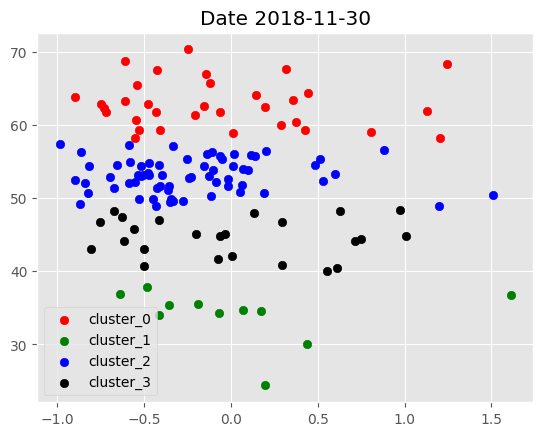

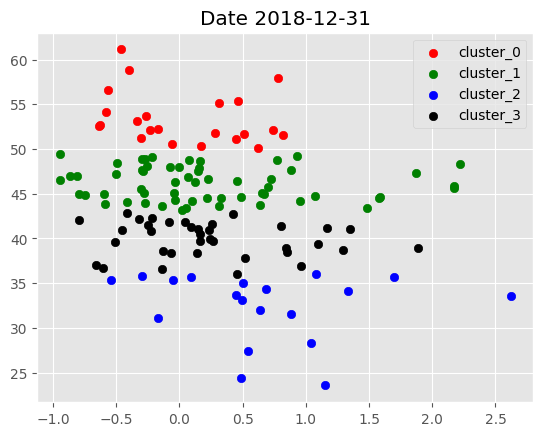

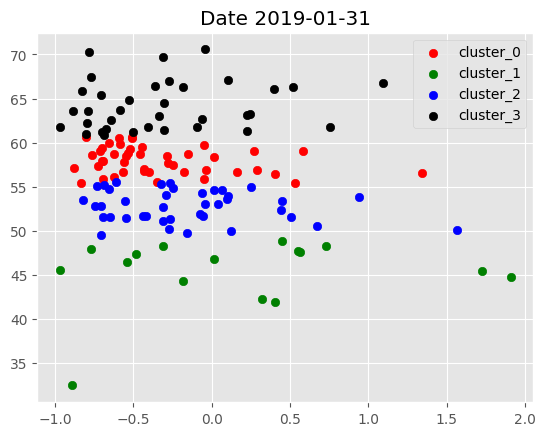

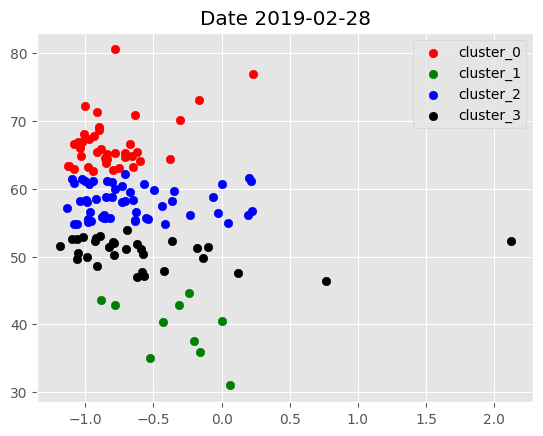

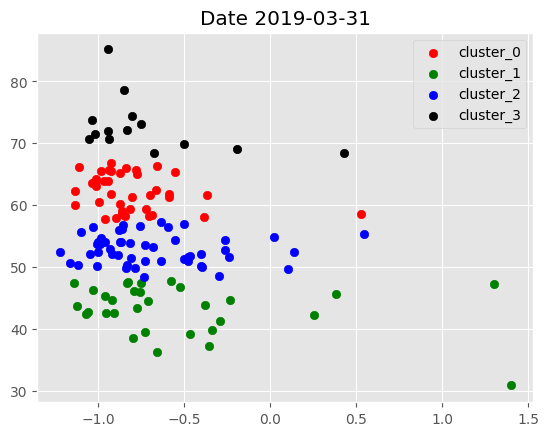

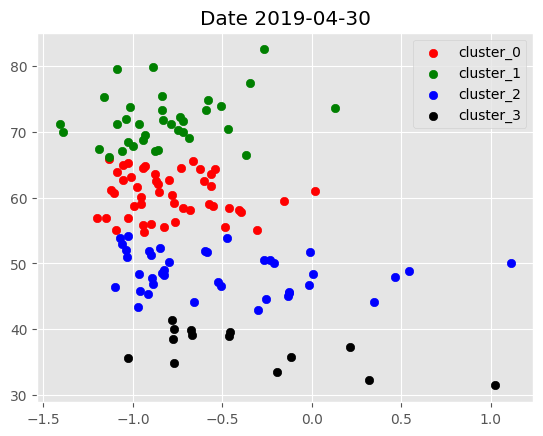

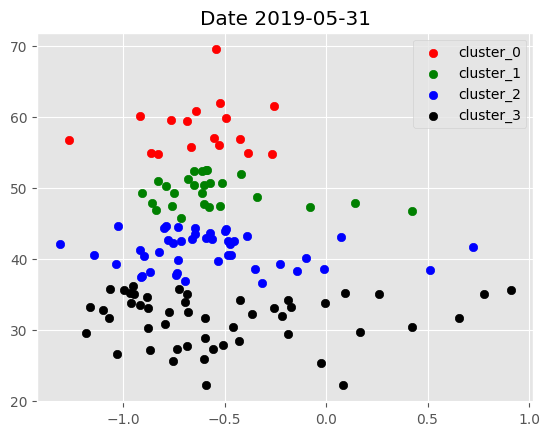

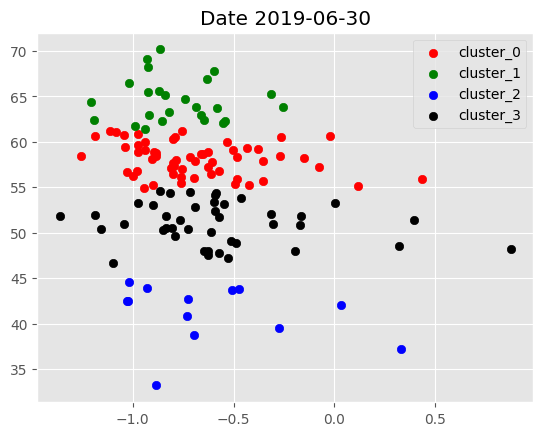

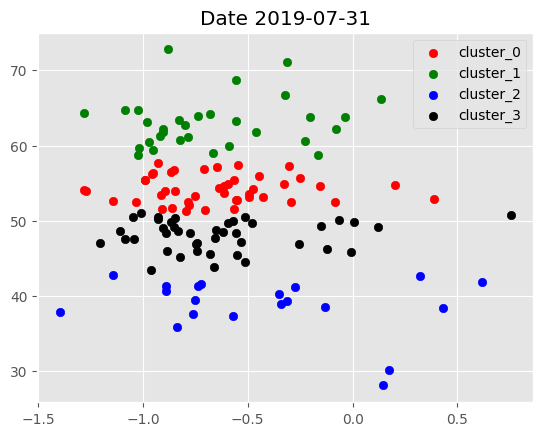

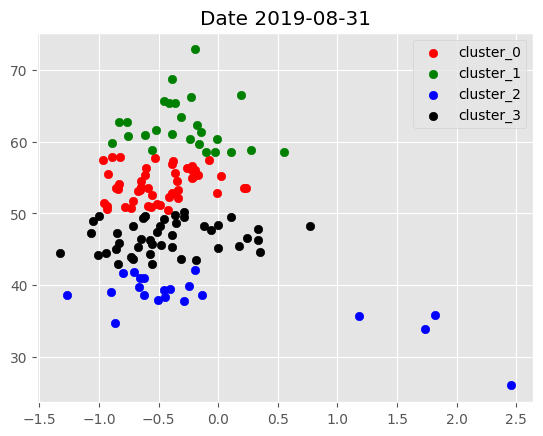

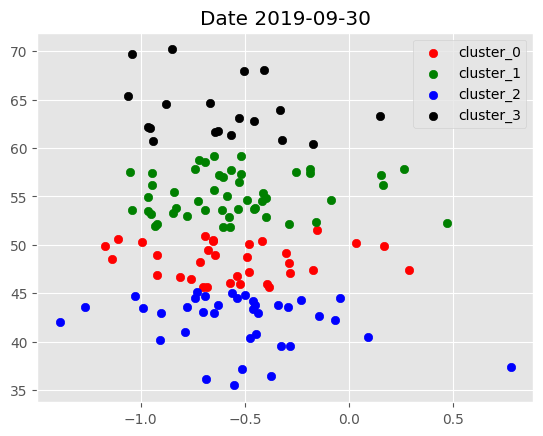

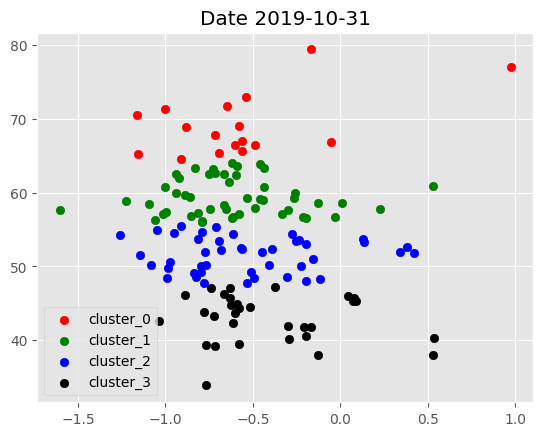

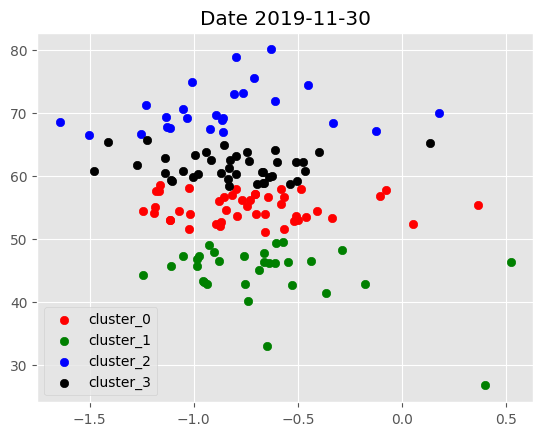

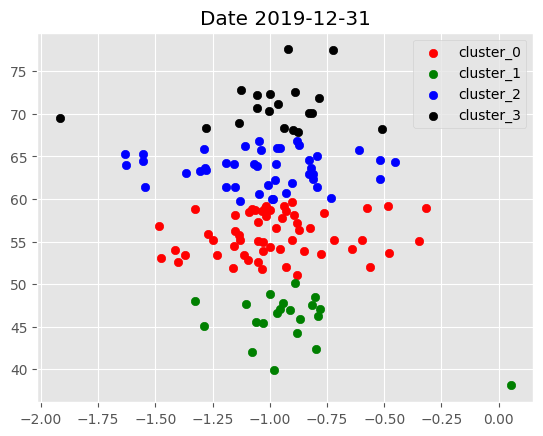

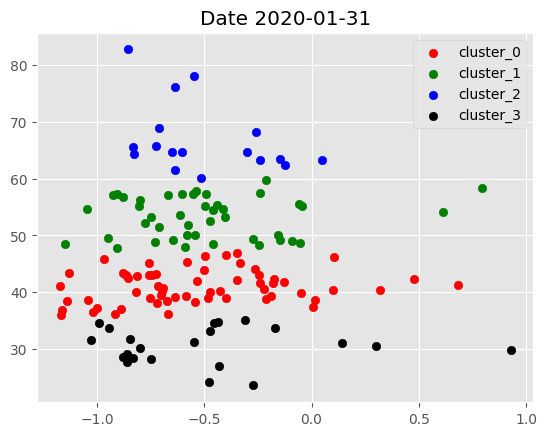

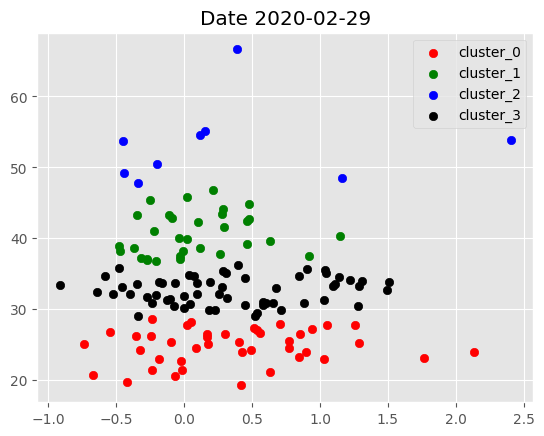

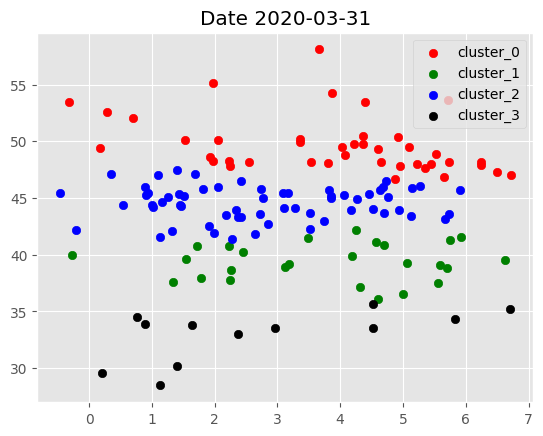

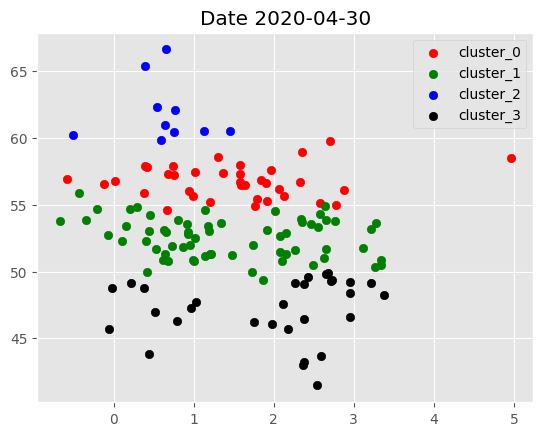

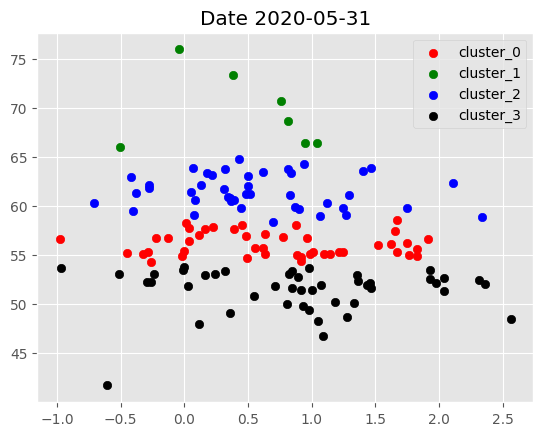

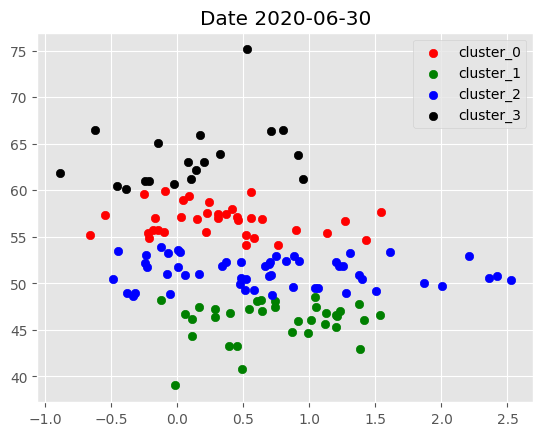

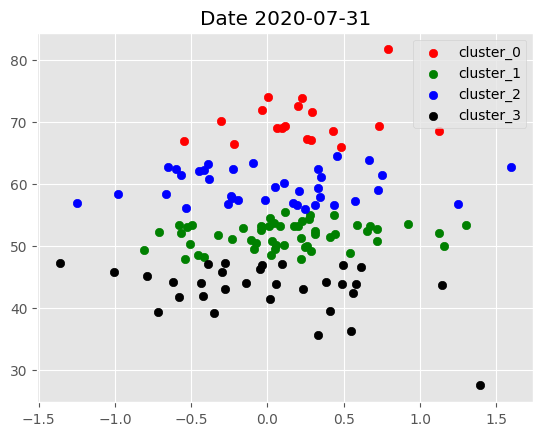

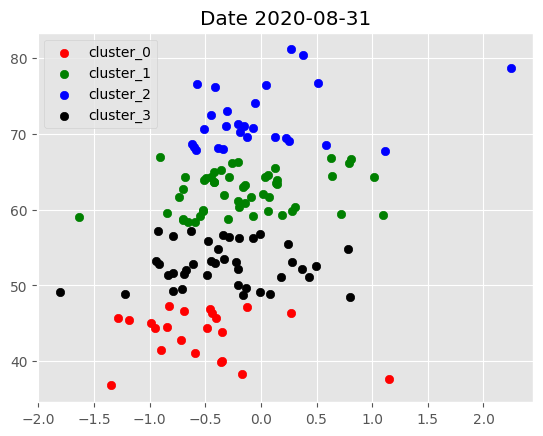

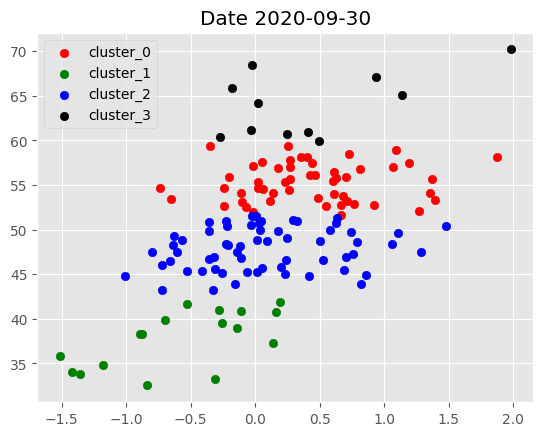

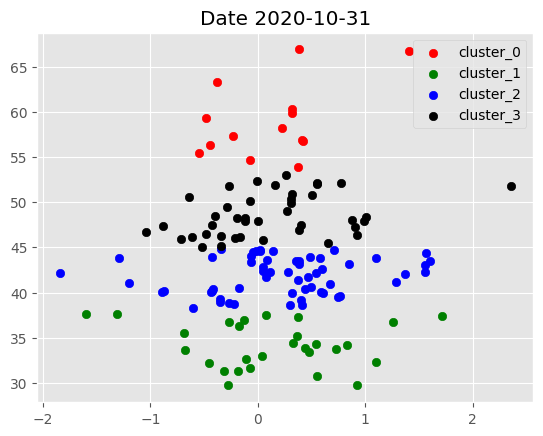

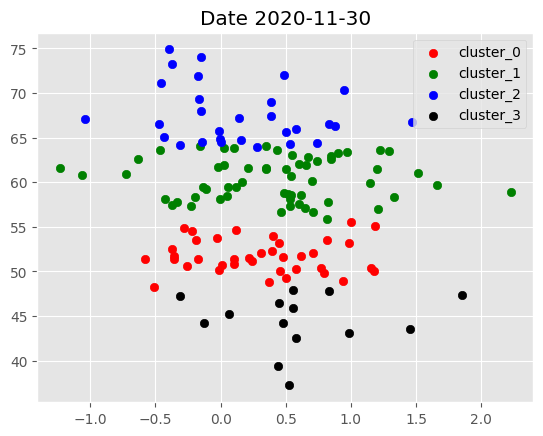

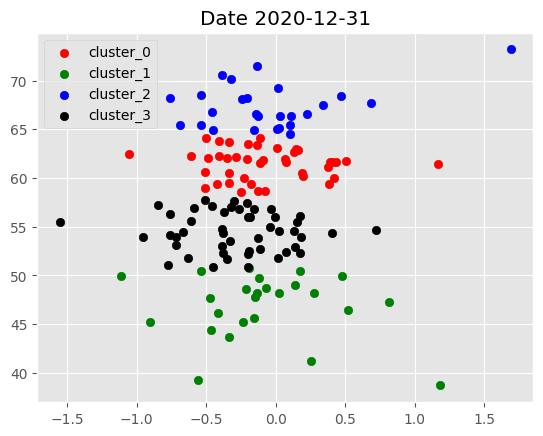

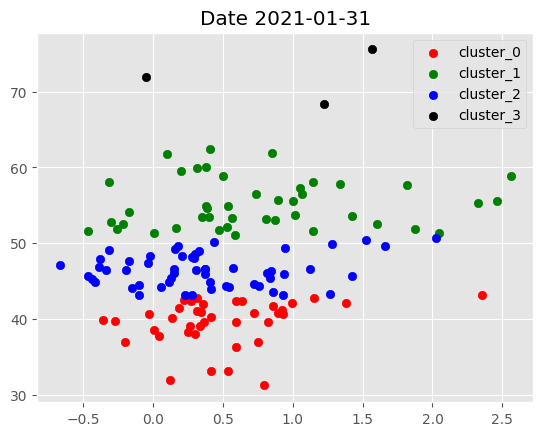

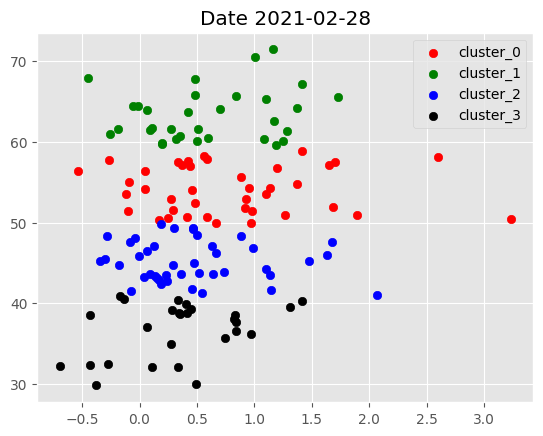

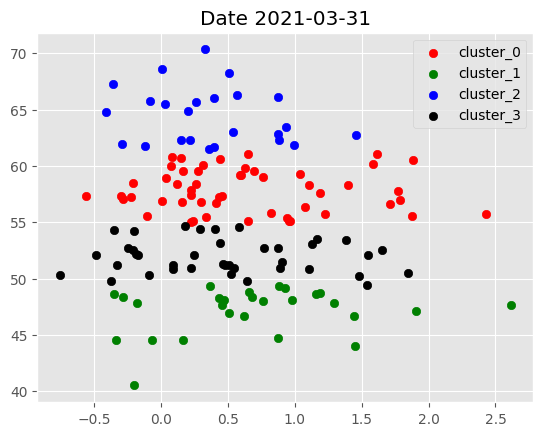

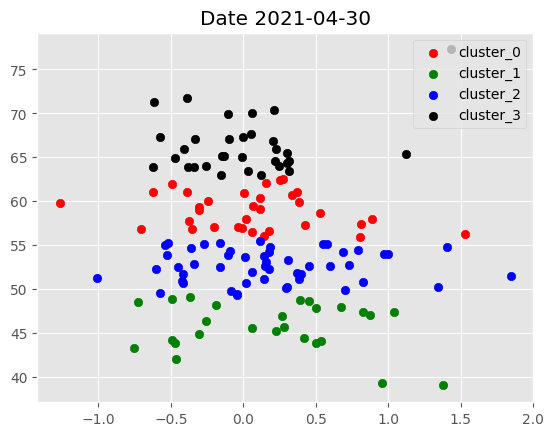

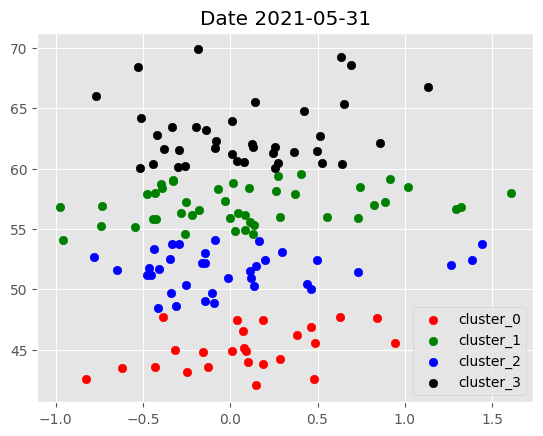

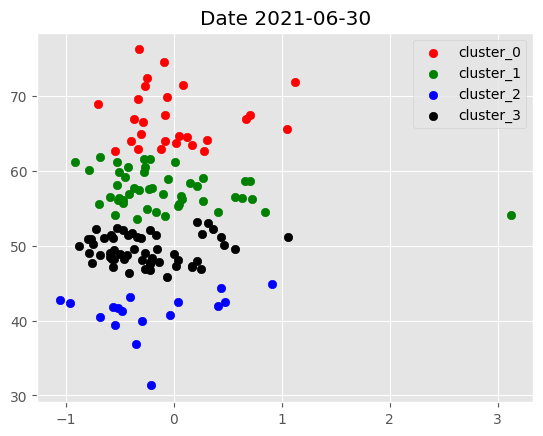

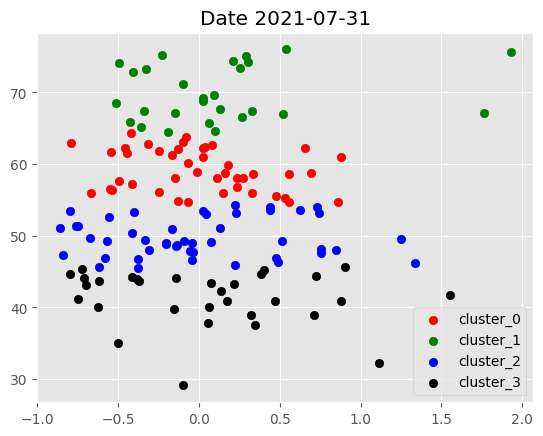

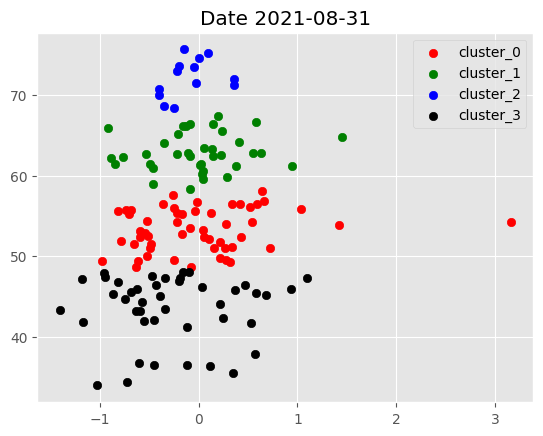

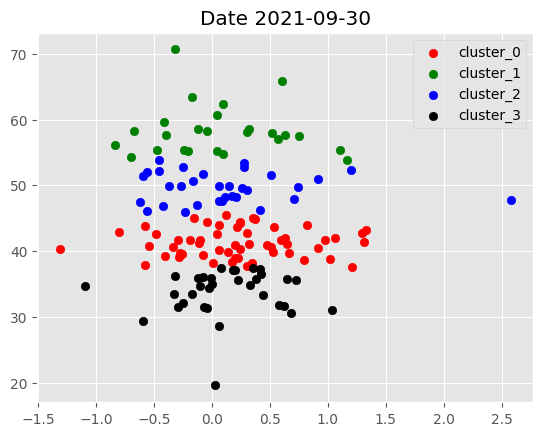

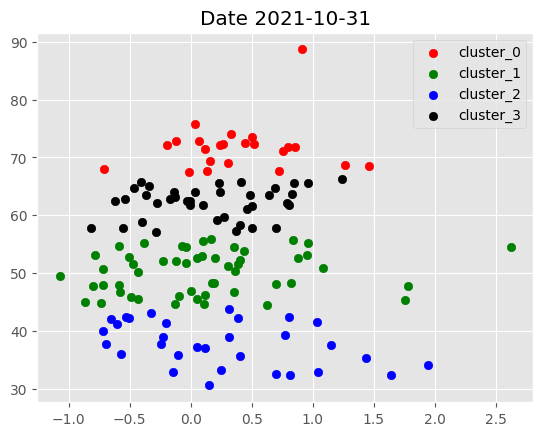

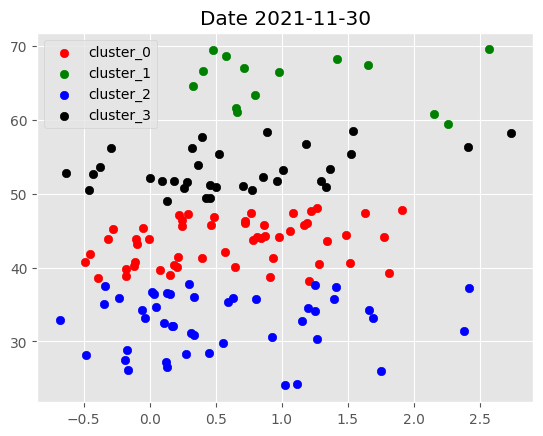

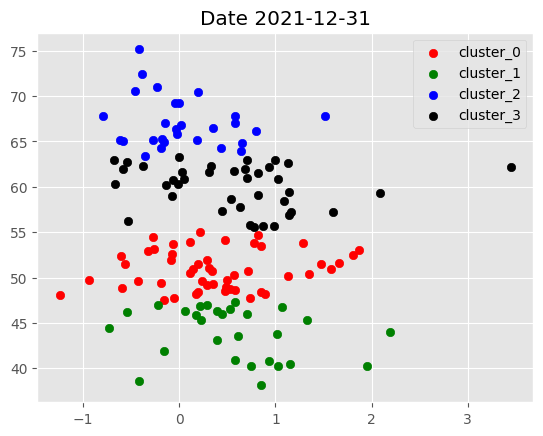

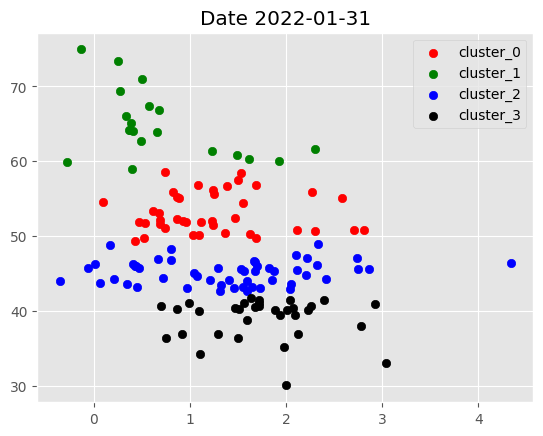

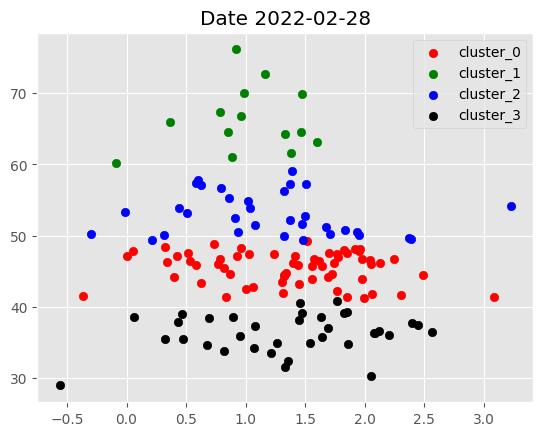

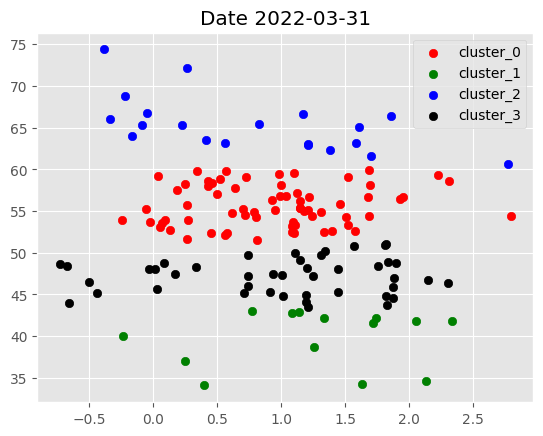

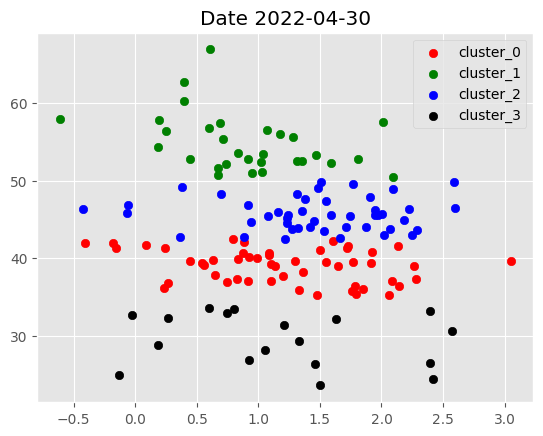

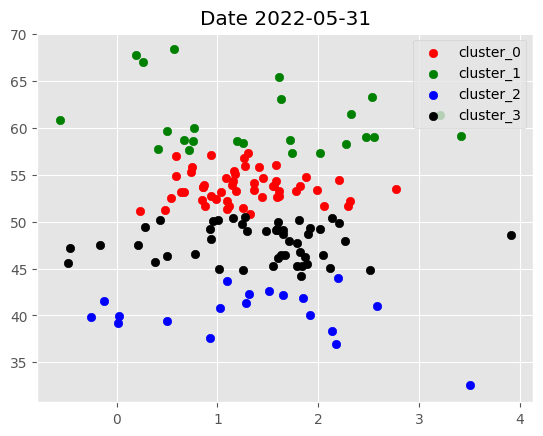

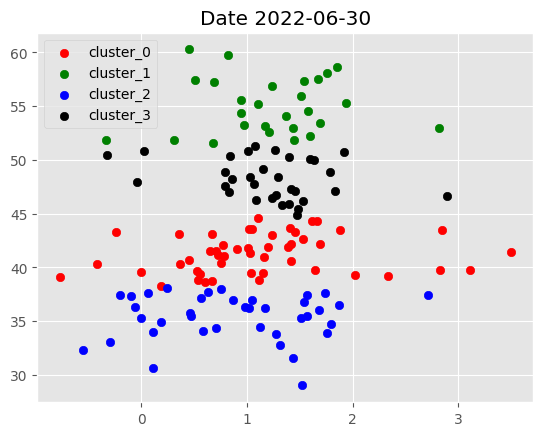

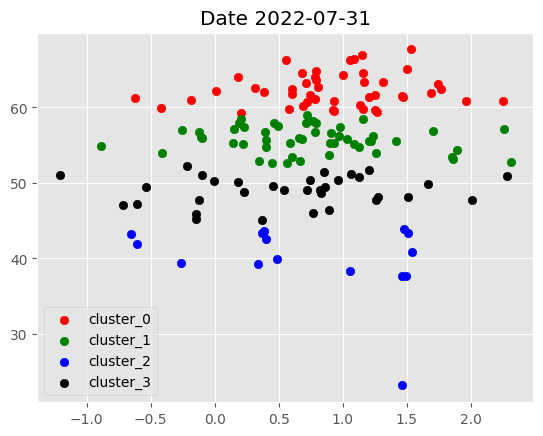

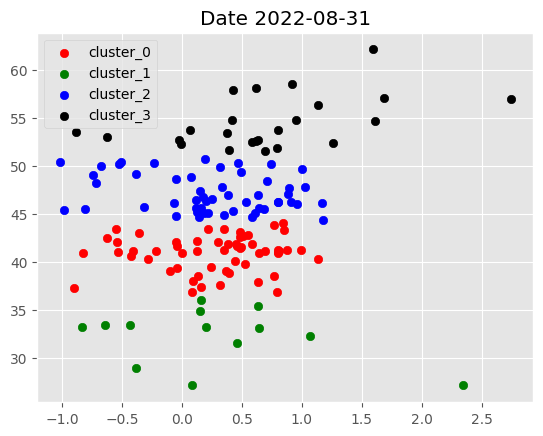

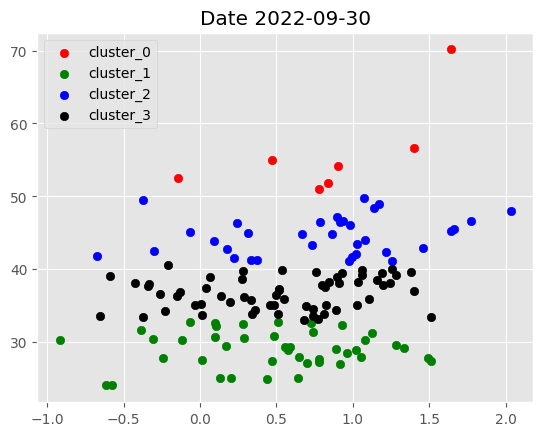

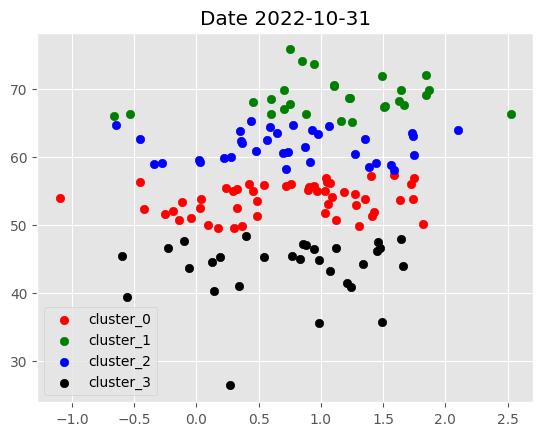

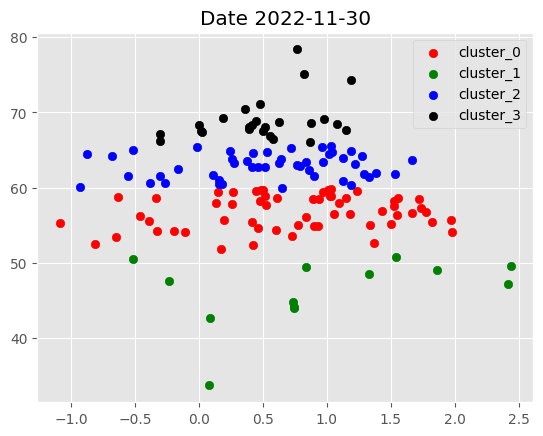

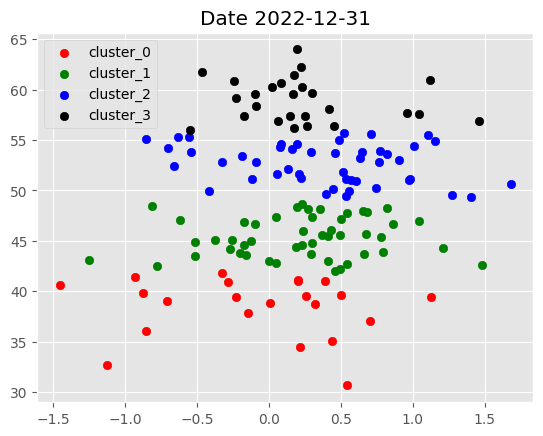

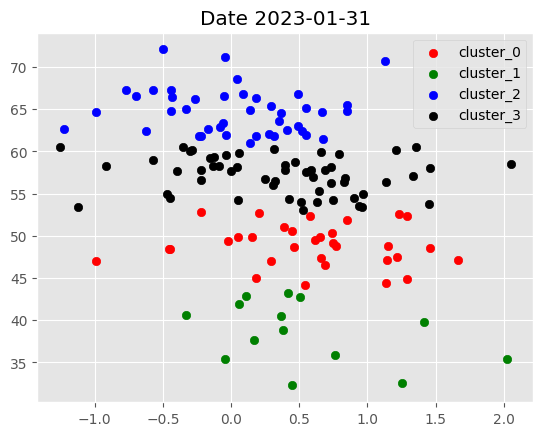

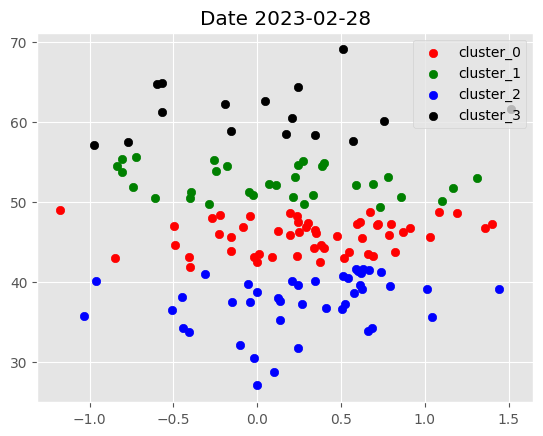

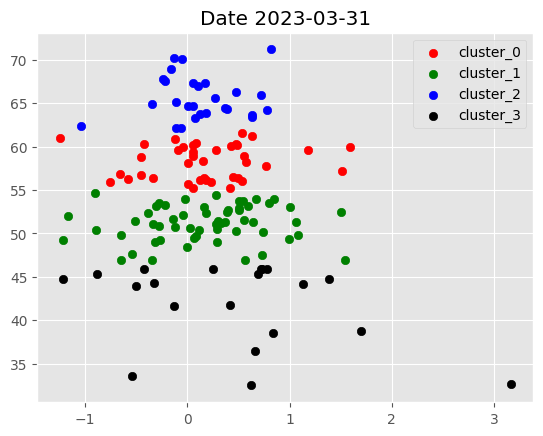

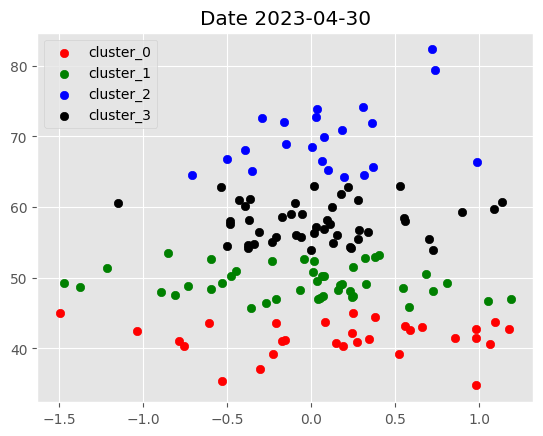

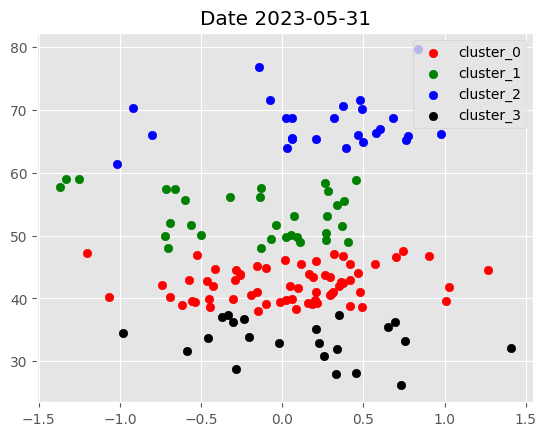

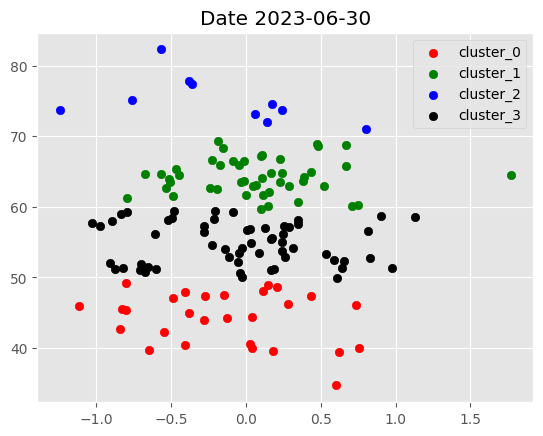

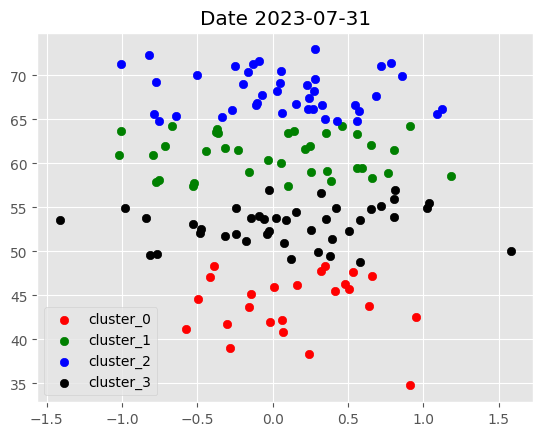

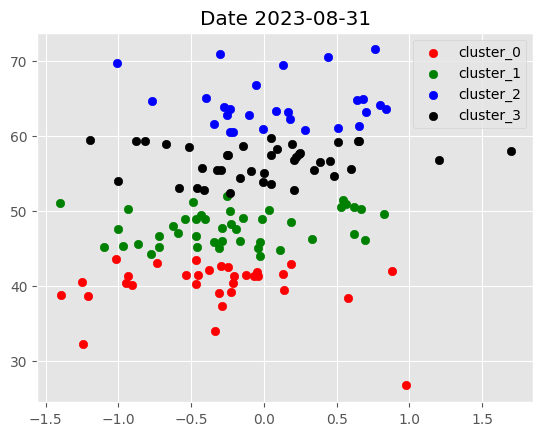

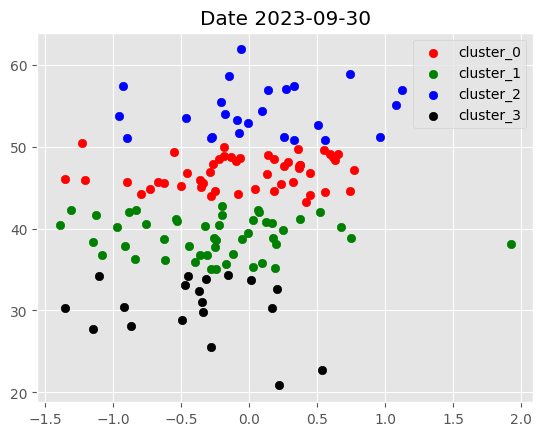

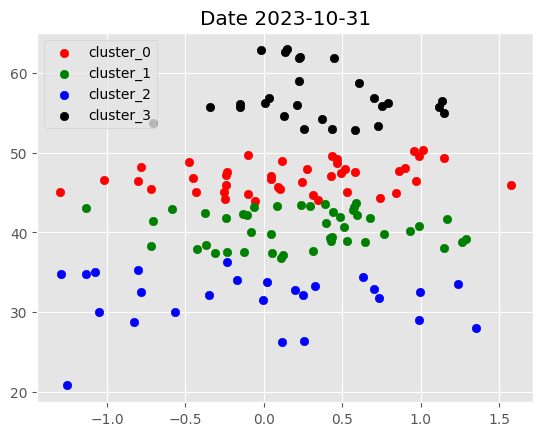

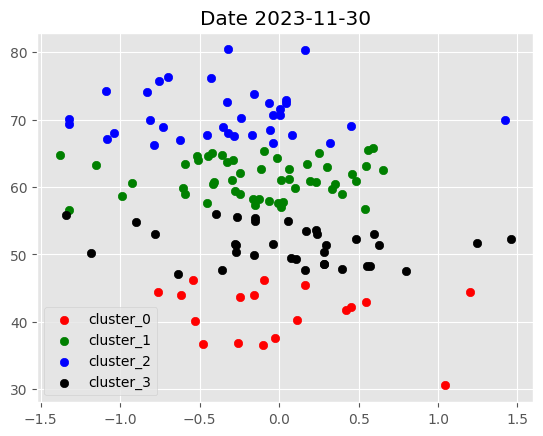

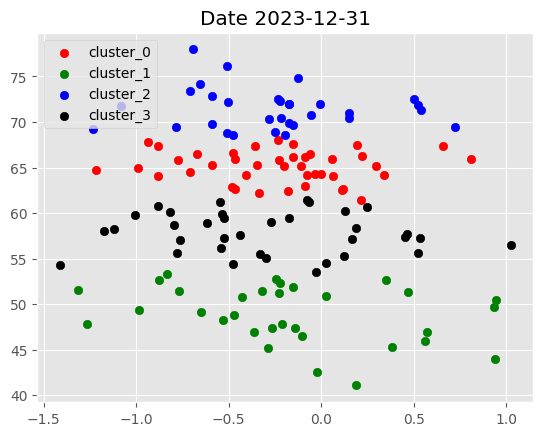

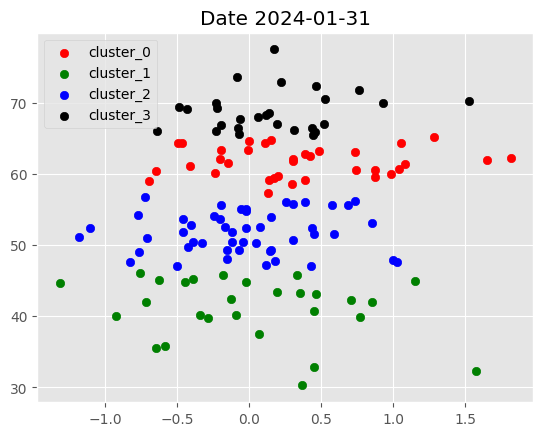

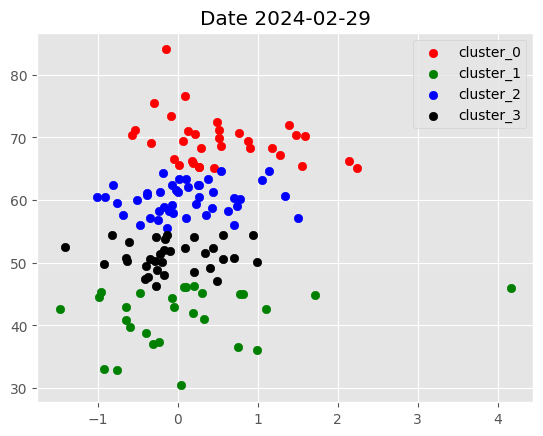

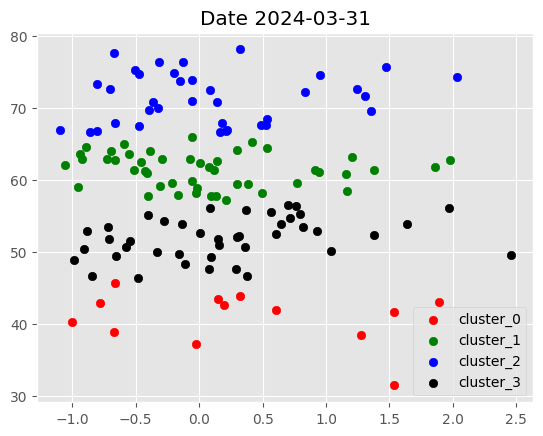

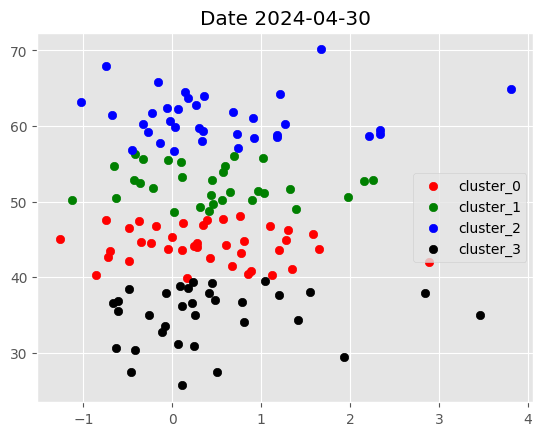

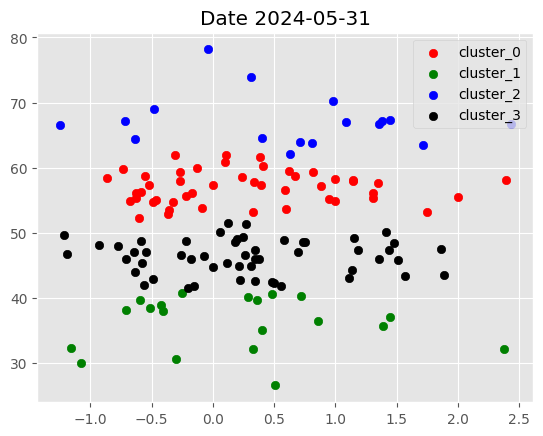

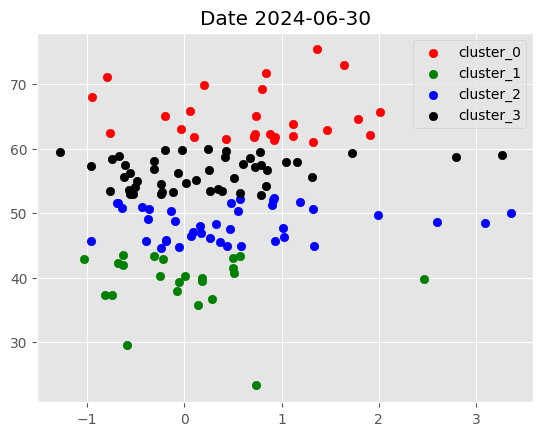

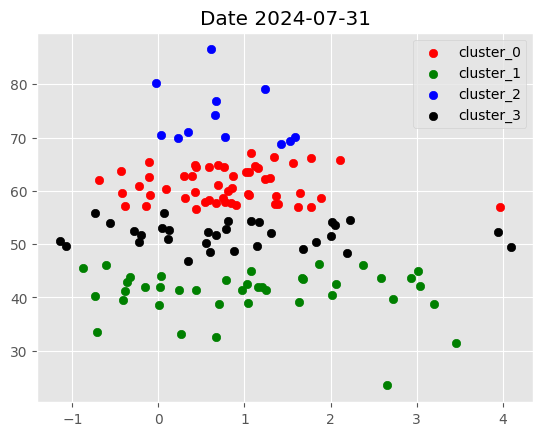

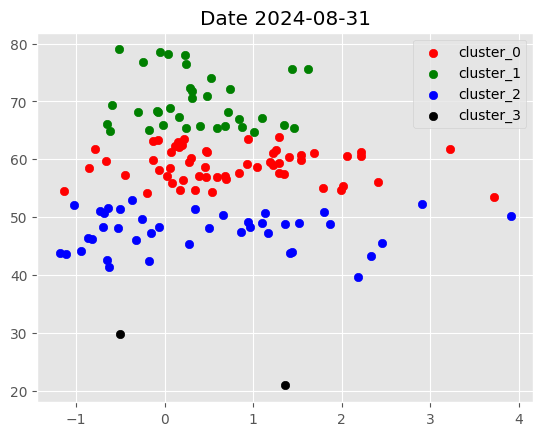

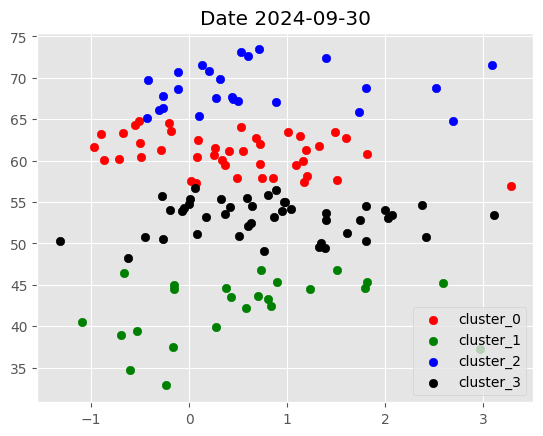

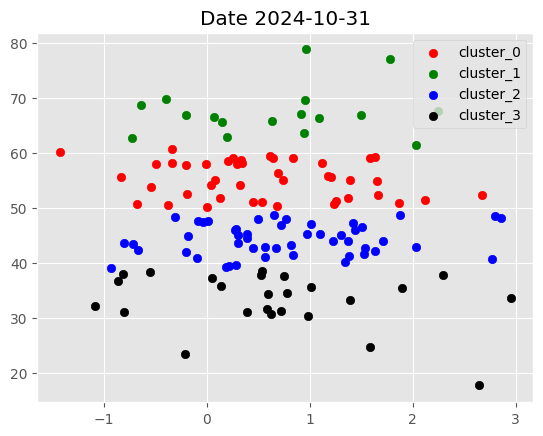

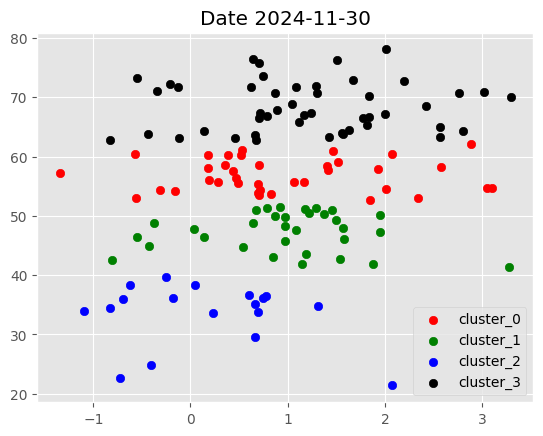

In [ ]:
#actually plotting

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level = 0)
    plt.title(f'Date {i}')
    plot_clusters(g)

#an observation i made was that the clusters are grouped based on RSI values
#clusters more or less are grouped as >60, 50-60, 40-50 and <40